In [2]:
import os
import random
import json
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import IPython.display as ipd
import datasets

import torch
import torch.nn as nn
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2CTCTokenizer, Wav2Vec2Processor
from jiwer import wer


from typing import List, Tuple, Set, Dict
%matplotlib inline

/home/artur/files/Audio Processing/phoneme_recognition/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

This section contains a modified version of the original function, adapted from [here](https://www.kaggle.com/code/vitouphy/phoneme-recognition-with-wav2vec2/notebook) and [here](https://huggingface.co/blog/fine-tune-wav2vec2-english) to fit our specific task requirements.

In [3]:
timit_path = "./timit/"
timit_data_path = "./timit/data/"

In [4]:
df_train = pd.read_csv(os.path.join(timit_path, 'train_data.csv'))
df_test = pd.read_csv(os.path.join(timit_path, 'test_data.csv'))
df = pd.concat([df_train, df_test])
df = df[df['is_converted_audio'] == False]

In [5]:
df_train = df[df['test_or_train'] == "TRAIN"]
df_test  = df[df['test_or_train'] == "TEST"]

In [6]:
df_train

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False
5,6.0,TRAIN,DR4,MMDM0,SI681.TXT,TRAIN/DR4/MMDM0/SI681.TXT,TRAIN\\DR4\\MMDM0\\SI681.TXT,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
23093,23094.0,TRAIN,DR8,MRDM0,SX245.TXT,TRAIN/DR8/MRDM0/SX245.TXT,TRAIN\\DR8\\MRDM0\\SX245.TXT,False,False,False,NaN,True
23094,23095.0,TRAIN,DR8,MRDM0,SI1044.PHN,TRAIN/DR8/MRDM0/SI1044.PHN,TRAIN\\DR8\\MRDM0\\SI1044.PHN,False,False,False,NaN,False
23096,23097.0,TRAIN,DR8,MRDM0,SX245.WAV,TRAIN/DR8/MRDM0/SX245.WAV,TRAIN\\DR8\\MRDM0\\SX245.WAV,False,True,False,NaN,False
23098,23099.0,TRAIN,DR8,MRDM0,SX335.WAV,TRAIN/DR8/MRDM0/SX335.WAV,TRAIN\\DR8\\MRDM0\\SX335.WAV,False,True,False,NaN,False


In [7]:
df_test

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,1.0,TEST,DR4,MGMM0,SX139.WAV,TEST/DR4/MGMM0/SX139.WAV,TEST\\DR4\\MGMM0\\SX139.WAV,False,True,False,False,False
2,3.0,TEST,DR4,MGMM0,SX139.TXT,TEST/DR4/MGMM0/SX139.TXT,TEST\\DR4\\MGMM0\\SX139.TXT,False,False,False,False,True
3,4.0,TEST,DR4,MGMM0,SI499.WRD,TEST/DR4/MGMM0/SI499.WRD,TEST\\DR4\\MGMM0\\SI499.WRD,False,False,True,False,False
4,5.0,TEST,DR4,MGMM0,SX319.WRD,TEST/DR4/MGMM0/SX319.WRD,TEST\\DR4\\MGMM0\\SX319.WRD,False,False,True,False,False
5,6.0,TEST,DR4,MGMM0,SX319.PHN,TEST/DR4/MGMM0/SX319.PHN,TEST\\DR4\\MGMM0\\SX319.PHN,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8394,8395.0,TEST,DR8,MPAM0,SX19.WAV,TEST/DR8/MPAM0/SX19.WAV,TEST\\DR8\\MPAM0\\SX19.WAV,False,True,False,False,False
8395,8396.0,TEST,DR8,MPAM0,SX109.TXT,TEST/DR8/MPAM0/SX109.TXT,TEST\\DR8\\MPAM0\\SX109.TXT,False,False,False,False,True
8397,8398.0,TEST,DR8,MPAM0,SX289.WRD,TEST/DR8/MPAM0/SX289.WRD,TEST\\DR8\\MPAM0\\SX289.WRD,False,False,True,False,False
8398,8399.0,TEST,DR8,MPAM0,SX109.WAV,TEST/DR8/MPAM0/SX109.WAV,TEST\\DR8\\MPAM0\\SX109.WAV,False,True,False,False,False


In this part, we will process the raw data to structure the dataset into three columns:

1. Path to the audio file
2. Text from the audio
3. Corresponding phonemes

Additionally, we will filter out any samples lacking phoneme data, as they cannot be used for training or testing without labels.

In [8]:
PHONETIC_KEY: str = "phonetic"
AUDIO_KEY:    str = "audio"
WORD_KEY:     str = "word"


def convert_phon61_to_phon39(sentence: str) -> str:
    phon61_map39 = {
        'iy':'iy',  'ih':'ih',  'eh':'eh',  'ae':'ae',   'ix':'ih',  'ax':'ah',  'ah':'ah',   'uw':'uw',
        'ux':'uw',  'uh':'uh',  'ao':'aa',  'aa':'aa',   'ey':'ey',  'ay':'ay',  'oy':'oy',   'aw':'aw',
        'ow':'ow',  'l':'l',    'el':'l',   'r':'r',     'y':'y',    'w':'w',    'er':'er',   'axr':'er',
        'm':'m',    'em':'m',   'n':'n',    'nx':'n',    'en':'n',   'ng':'ng',  'eng':'ng',  'ch':'ch',
        'jh':'jh',  'dh':'dh',  'b':'b',    'd':'d',     'dx':'dx',  'g':'g',    'p':'p',     't':'t',
        'k':'k',    'z':'z',    'zh':'sh',  'v':'v',     'f':'f',    'th':'th',  's':'s',     'sh':'sh',
        'hh':'hh',  'hv':'hh',  'pcl':'h#', 'tcl':'h#',  'kcl':'h#', 'qcl':'h#', 'bcl':'h#',  'dcl':'h#',
        'gcl':'h#', 'h#':'h#',  '#h':'h#',  'pau':'h#',  'epi':'h#', 'nx':'n',   'ax-h':'ah', 'q':'h#'
    }
    tokens = [phon61_map39[x] for x in sentence.split()]
    return " ".join(tokens)


def read_text_file(filepath: str) -> str:
    with open(filepath) as f:
        tokens = [line.split()[-1] for line in f]
        return " ".join(tokens)


def merge_item_data(df: pd.DataFrame) -> Dict[str, Dict[str, str]]:
    data = {}

    for _, row in tqdm(df.iterrows()):
        path = row['path_from_data_dir']
        entry_id = path.split('.')[0]
        entry_id = "-".join(entry_id.split('/')[-2:])

        if entry_id not in data:
            data[entry_id] = {}

        if row['is_audio'] is True:
            data[entry_id][AUDIO_KEY] = os.path.join(timit_data_path, path)
        elif row['is_word_file'] is True:
            data[entry_id][WORD_KEY] = read_text_file(os.path.join(timit_data_path, path))
        elif row['is_phonetic_file'] is True:
            phoneme_sentence = read_text_file(os.path.join(timit_data_path, path))
            data[entry_id][PHONETIC_KEY] = convert_phon61_to_phon39(phoneme_sentence)
    return data


def transform_dataset(df: pd.DataFrame) -> Dict[str, List[str]]:
    merged_data = merge_item_data(df)

    phonetic_files: List[str] = []
    audio_files:    List[str] = []
    word_files:     List[str] = []
    keys_set:       Set[str]  = set([PHONETIC_KEY, AUDIO_KEY, WORD_KEY])

    for _, value in merged_data.items():
        if set(value) == keys_set:
            phonetic_files.append(value[PHONETIC_KEY])
            audio_files.append(value[AUDIO_KEY])
            word_files.append(value[WORD_KEY])

    return {
        AUDIO_KEY: audio_files,
        WORD_KEY: word_files,
        PHONETIC_KEY: phonetic_files
    }

In [9]:
train_val = transform_dataset(df_train)
test = transform_dataset(df_test)

18480it [00:01, 9607.02it/s] 
6720it [00:00, 7751.69it/s]


In [10]:
random.seed(42)
n = len(train_val[AUDIO_KEY])
train_n = int(n * 0.9)
val_n = n - train_n

val_ind = np.array(sorted(random.sample(range(0, n), val_n)))
train_ind = np.array(sorted(list(set(range(0, n)) - set(val_ind))))

In [11]:
train = dict()
val = dict()

for key in [AUDIO_KEY, WORD_KEY, PHONETIC_KEY]:
    train[key] = np.array(train_val[key])[train_ind].tolist()
    val[key]   = np.array(train_val[key])[val_ind].tolist()

In [12]:
print(f"Train set length: {len(train[AUDIO_KEY])}")
print(f"Validation set length: {len(val[AUDIO_KEY])}")
print(f"Test set length: {len(test[AUDIO_KEY])}")

Train set length: 1512
Validation set length: 168
Test set length: 1680


Now let's convert the data to a data type that the model will work with.

In [13]:
train_dataset = datasets.Dataset.from_dict(train)
val_dataset   = datasets.Dataset.from_dict(val)
test_dataset  = datasets.Dataset.from_dict(test)

In [14]:
train_dataset = train_dataset.cast_column(AUDIO_KEY, datasets.Audio(sampling_rate=16_000))
val_dataset   = val_dataset.cast_column(AUDIO_KEY, datasets.Audio(sampling_rate=16_000))
test_dataset  = test_dataset.cast_column(AUDIO_KEY, datasets.Audio(sampling_rate=16_000))

In [15]:
ind = 10

print("Text:", train_dataset[ind][WORD_KEY])
print("Phonetics:", train_dataset[ind][PHONETIC_KEY])
print("Input array shape:", train_dataset[ind][AUDIO_KEY]["array"].shape)
print("Sampling rate:", train_dataset[ind][AUDIO_KEY]["sampling_rate"])
ipd.Audio(data=train_dataset[ind][AUDIO_KEY]["array"], autoplay=False, rate=16000)

Text: get a calico cat to keep
Phonetics: h# g ih dx ih h# k ae l ih h# k ow h# k ae h# t ah h# k iy h# p h#
Input array shape: (32359,)
Sampling rate: 16000


#### Phonemes vocabulary

The Wav2Vec2 Tokenizer requires a dictionary of all possible string values to map them into numerical representations. Below, we will construct this dictionary, including special tokens such as delimiters, padding symbols, and other control characters.

In [16]:
train_phonetics = [phone for x in train_dataset for phone in x[PHONETIC_KEY].split()]
val_phonetics   = [phone for x in val_dataset for phone in x[PHONETIC_KEY].split()]
test_phonetics  = [phone for x in test_dataset for phone in x[PHONETIC_KEY].split()]

In [17]:
vocab_list = list(set(train_phonetics) | set(val_phonetics) | set(test_phonetics) | set([' ']))

vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
print(vocab_dict)

{' ': 0, 'aa': 1, 'ae': 2, 'ah': 3, 'aw': 4, 'ay': 5, 'b': 6, 'ch': 7, 'd': 8, 'dh': 9, 'dx': 10, 'eh': 11, 'er': 12, 'ey': 13, 'f': 14, 'g': 15, 'h#': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'm': 23, 'n': 24, 'ng': 25, 'ow': 26, 'oy': 27, 'p': 28, 'r': 29, 's': 30, 'sh': 31, 't': 32, 'th': 33, 'uh': 34, 'uw': 35, 'v': 36, 'w': 37, 'y': 38, 'z': 39}


In [18]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
print(len(vocab_dict))

42


Let's save the dictionary to a json file, from which the Tokenizer will read it.

In [19]:
with open('./vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

We will also clean the memory of unnecessary data.

In [20]:
del df
del df_test
del df_train

# Modeling

### Wav2Vec2 

**Wav2Vec2** cannot process raw audio directly, so we transform the input data into a suitable format using the **Wav2Vec2FeatureExtractor**. Additionally, since the model operates on numerical inputs, we convert the phoneme-based text labels into discrete tokens using the **Wav2Vec2Tokenizer**.

For initialization, we load the pretrained weights for both Wav2Vec2 and the FeatureExtractor from the base model. We also enable the `output_hidden_states` flag in Wav2Vec2 to extract features from different layers, allowing us to analyze which representations perform best for our task.

In [21]:
DEVICE = "cuda"

ssl_model_name = "facebook/wav2vec2-base-960h"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(ssl_model_name)
tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

ssl_model = Wav2Vec2Model.from_pretrained(ssl_model_name, output_hidden_states=True).to(DEVICE)
ssl_model.eval()

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

Let’s examine the number of layers in Wav2Vec2 and the dimensionality of their outputs.

In [22]:
ind: int = 0
inputs = processor(train_dataset['audio'][ind]['array'], 
                   sampling_rate=train_dataset['audio'][ind]['sampling_rate'], 
                   return_tensors="pt", 
                   padding=True).input_values.to(DEVICE)

with torch.no_grad():
    outputs = ssl_model(inputs)

hidden_states = outputs.hidden_states
for i, hs in enumerate(hidden_states):
    print(f"Layer {i}: {hs.shape}")

Layer 0: torch.Size([1, 270, 768])
Layer 1: torch.Size([1, 270, 768])
Layer 2: torch.Size([1, 270, 768])
Layer 3: torch.Size([1, 270, 768])
Layer 4: torch.Size([1, 270, 768])
Layer 5: torch.Size([1, 270, 768])
Layer 6: torch.Size([1, 270, 768])
Layer 7: torch.Size([1, 270, 768])
Layer 8: torch.Size([1, 270, 768])
Layer 9: torch.Size([1, 270, 768])
Layer 10: torch.Size([1, 270, 768])
Layer 11: torch.Size([1, 270, 768])
Layer 12: torch.Size([1, 270, 768])


We observe that Wav2Vec2 comprises **13 layers**, each producing output tensors of identical dimensionality: **(1, 270, 768)**. Here:

- **1** represents the batch size,
- **270** corresponds to the number of segmented audio samples (variable with audio length, default(also max)=270),
- **768** denotes the feature dimension.

Notably, the **sample count (270)** varies with input duration — shorter audio yields fewer samples to retain essential information. This variability impacts training; we address this later.

Next, we construct a modified dataset `PhonemeDataset` for training. Key properties:

- **Layer-specific features**: Extracts outputs from a user-defined Wav2Vec2 layer (indexed backward: layer=1 = last hidden layer, layer=13 = first layer).
- **Preprocessing**: Automatically generates features and converts phoneme labels to numerical tokens during initialization.

In [23]:
from torch.utils.data import DataLoader, Dataset

class PhonemeDataset(Dataset):
    def __init__(self, data: datasets.Dataset, layer: int, save_extra_data: bool = False):
        self.data = []
        self.extra_data = []

        print("Preprocessing data...")
        for audio, phonetic in tqdm(zip(data[AUDIO_KEY], data[PHONETIC_KEY])):
            input = processor(audio["array"], 
                              sampling_rate=audio["sampling_rate"], 
                              return_tensors="pt", 
                              padding=True).input_values.to(DEVICE)
            with torch.no_grad():
                outputs = ssl_model(input)
            features = outputs.hidden_states[-layer].cpu()

            with processor.as_target_processor():
                labels = processor(phonetic).input_ids

            self.data.append({
                'features': features[0],
                'labels': torch.tensor(labels)
            })

        if save_extra_data:
            print("Saving extra data...")
            for audio, words, phonetic in tqdm(zip(data[AUDIO_KEY], data[WORD_KEY], data[PHONETIC_KEY])):
                self.extra_data.append({
                    AUDIO_KEY: audio,
                    WORD_KEY: words,
                    PHONETIC_KEY: phonetic
                })

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        return self.data[idx]


    def get_extra_data(self, idx: int) -> Dict:
        if len(self.extra_data) == 0:
            raise ValueError("Extra data is missing")
        return self.extra_data[idx]

In [24]:
train_dataset_sc = PhonemeDataset(train_dataset, 1)
val_dataset_sc   = PhonemeDataset(val_dataset, 1)
test_dataset_sc  = PhonemeDataset(test_dataset, 1, save_extra_data=True)

Preprocessing data...


0it [00:00, ?it/s]/home/artur/files/Audio Processing/phoneme_recognition/venv/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
1512it [00:35, 43.02it/s]


Preprocessing data...


168it [00:03, 43.93it/s]


Preprocessing data...


1680it [00:38, 43.58it/s]


Saving extra data...


1680it [00:00, 1530834.39it/s]


### Heads

This section implements all proposed Head architectures:

- Linear
- MLP
- Reccurent(GRU or LSTM)
- Convolutional
- Attention

The depth of each Head is carefully balanced to be not too shallow to ensure sufficient modeling capacity and not too deep to avoid shifting the core phoneme recognition task from the Wav2Vec2 backbone to the Head

In [25]:
class LinearHead(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim)


    def forward(self, x):
        return self.fc(x)



class MLPHead(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, dropout_prob: float, output_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x



class ReccurentHead(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, num_layers: int, output_dim: int, model_type: str = "GRU"):
        super().__init__()
        if model_type == "GRU":
            self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            raise ValueError("Model type must be GRU or LSTM")
        
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        x, _ = self.rnn(x)
        return self.fc(x)



class ConvHead(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, channels: int, kernel_size: int = 3):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, 
                               out_channels=channels, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.conv2 = nn.Conv1d(in_channels=channels, 
                               out_channels=output_dim, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = x.permute(0, 2, 1) #(BATCH, FEATURES, SEQ)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x.permute(0, 2, 1) #(BATCH, SEQ, FEATURES)



class AttentionHead(nn.Module):
    def __init__(self, input_dim: int, num_heads: int, output_dim: int):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)
        self.fc = nn.Linear(input_dim, output_dim)


    def forward(self, x):
        x, _ = self.attn(x, x, x)
        return self.fc(x)

### Utils

The following are auxiliary functions used during the training and evaluation of the models.

The `data_collator` is used by the **Dataloader** to ensure proper data handling during batching. As mentioned earlier, some audio samples are shorter than others, which means a batch can contain audio inputs of varying lengths. To correctly combine these into a single tensor, all samples are padded to match the length of the longest audio in the batch.

The `predict_phonemes` function uses the model to predict phonemes and then processes the model's output to produce the final result. Since our task is sequence-to-sequence, a phoneme is predicted for each sample. As a result, we may obtain up to 270 predicted phonemes, which is typically more than expected, because multiple samples may correspond to a single phoneme. This can lead to repeated phonemes in the output. However, since phonemes are separated by a special delimiter, we can accurately segment the sequence and merge repeating phonemes into a single instance. This produces a cleaned-up predicted phoneme sequence.

The remaining functions are either utility functions for showing results or basic implementations of training and evaluation procedures. As they are straightforward, there is no need to describe them in detail.

In [26]:
def data_collator(batch: List[Dict[str, torch.tensor]]):    
    features = [sample['features'] for sample in batch]
    labels   = [sample['labels'] for sample in batch]
    padded_features = torch.nn.utils.rnn.pad_sequence(features, batch_first=True)

    labels_length = torch.tensor([len(label) for label in labels], dtype=torch.long)
    labels = torch.cat([label.clone().detach().long() for label in labels])
    return padded_features, labels, labels_length

In [27]:
def predict_phonemes(model: nn.Module, features: torch.Tensor, reversed_vocab_dict: Dict[int, str], ctc_blank: int) -> str:
    features = features.to(DEVICE)

    with torch.no_grad():
        logits = model(features).cpu()

    probs = torch.softmax(logits, dim=-1)
    preds = torch.argmax(probs, dim=-1).squeeze().numpy()

    merged = [preds[0]]
    for pred in preds:
        if pred != merged[-1]:
            merged.append(pred)
    
    result = []
    for val in merged:
        if val != ctc_blank and val in reversed_vocab_dict:
            result.append(reversed_vocab_dict[val])

    return " ".join(result)


def show_results(model: nn.Module, dataset: PhonemeDataset, idx: int, reversed_vocab_dict: Dict[int, str], ctc_blank: int) -> List[float]:
    data = dataset.get_extra_data(idx)
    text = data[WORD_KEY]
    phonetics = data[PHONETIC_KEY]
    audio = data[AUDIO_KEY]["array"]
    
    features, _, _ = data_collator([dataset[idx]])
    features = features.to(DEVICE)
    prediction = predict_phonemes(model, features, reversed_vocab_dict, ctc_blank)
    
    print(f"Text: {text}")
    print(f"PER: {wer(reference=phonetics, hypothesis=prediction)}")
    print(f"Predicted phonetics:\n{phonetics}")
    print(f"Ground Truth phonetics:\n{prediction}")
    return audio

In [28]:
def train_epoch(model: nn.Module, train_loader: DataLoader, criterion: nn.Module, optimizer: torch.optim, disable_tqdm: bool = False) -> float:
    train_loss = 0.0

    model.train()
    for features, labels, labels_lengths in tqdm(train_loader, disable=disable_tqdm):
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)
        labels_lengths = labels_lengths.to(DEVICE)

        optimizer.zero_grad()
        logits = model(features)
        log_probs = torch.log_softmax(logits, dim=-1).permute(1, 0, 2) #(SEQ, BATCH, CLASSES)

        input_lengths = torch.full(
            size=(logits.size(0),), 
            fill_value=logits.size(1), 
            dtype=torch.long,
            device=DEVICE
        )
        
        loss = criterion(log_probs, labels, input_lengths, labels_lengths)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    return train_loss / len(train_loader)


def evaluate_model(model: nn.Module, val_loader: DataLoader, reversed_vocab_dict: Dict, ctc_blank: int, disable_tqdm: bool = False) -> float:
    total_per = 0.0

    model.eval()
    for features, labels, _ in tqdm(val_loader, disable=disable_tqdm):
        expected = []
        for val in labels.numpy():
            if val in reversed_vocab_dict:
                expected.append(reversed_vocab_dict[val])
        ground_truth = " ".join(expected)

        predicted = predict_phonemes(model, features, reversed_vocab_dict, ctc_blank)
        total_per += wer(ground_truth, predicted)
    return total_per / len(val_loader)


def train_model(model: nn.Module, 
                train_loader: DataLoader, 
                val_loader: DataLoader, 
                criterion: nn.Module, 
                optimizer: torch.optim, 
                reversed_vocab_dict: Dict, 
                ctc_blank: int,
                weights_path: str,
                num_epochs: int = 100,
                best_per: float = 1,
                disable_tqdm: bool = False) -> Tuple[float, float]:

    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion=criterion, optimizer=optimizer, disable_tqdm=disable_tqdm)
        val_per = evaluate_model(model, val_loader, reversed_vocab_dict, ctc_blank, disable_tqdm=disable_tqdm)
        if best_per - val_per > 0.001:
            torch.save(model.state_dict(), weights_path)
            best_per = val_per
        if not disable_tqdm:
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Train Loss: {train_loss}, "
                f"Validation PER: {val_per:.4f}")
    return train_loss, best_per

In [29]:
reversed_vocab_dict = dict()

for key in vocab_dict:
    reversed_vocab_dict[vocab_dict[key]] = key 

### Training

Now let's perform a quick training run using the **MLPHead** to ensure everything is functioning correctly. Interestingly, we are using `CTCLoss` here, which is well-suited for our task since it follows a sequence-to-sequence setup.

In [31]:
classes = len(vocab_dict) + 1
input_dim = 768
batch_size = 1
ctc_blank = len(vocab_dict)

model = MLPHead(input_dim=input_dim, 
                hidden_dim=512,
                dropout_prob=0.5,
                output_dim=classes).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ctc_loss = nn.CTCLoss(blank=ctc_blank)
train_loader = DataLoader(train_dataset_sc, collate_fn=data_collator, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset_sc, collate_fn=data_collator, batch_size=1)
test_loader  = DataLoader(test_dataset_sc, collate_fn=data_collator, batch_size=1)

In [32]:
train_loss, best_val_per = train_model(model=model, 
                                       train_loader=train_loader, 
                                       val_loader=val_loader, 
                                       criterion=ctc_loss, 
                                       optimizer=optimizer, 
                                       reversed_vocab_dict=reversed_vocab_dict, 
                                       ctc_blank=ctc_blank, 
                                       num_epochs=10,
                                       weights_path="./weights/wav2vec2/mlp.pt")

test_per = evaluate_model(model=model,
                          val_loader=test_loader,
                          reversed_vocab_dict=reversed_vocab_dict,
                          ctc_blank=ctc_blank)

print(f"\nFinal loss: {train_loss}")
print(f"Best validation PER: {best_val_per}")
print(f"Test PER: {test_per}")

100%|██████████| 168/168 [00:00<00:00, 1262.50it/s]


Epoch [1/10], Train Loss: 2.3680663706448972, Validation PER: 0.4791


100%|██████████| 168/168 [00:00<00:00, 1324.61it/s]


Epoch [2/10], Train Loss: 1.3375209299502548, Validation PER: 0.3857


100%|██████████| 168/168 [00:00<00:00, 1260.21it/s]


Epoch [3/10], Train Loss: 1.1600460184629633, Validation PER: 0.3468


100%|██████████| 168/168 [00:00<00:00, 1331.59it/s]


Epoch [4/10], Train Loss: 1.0549271246467633, Validation PER: 0.3335


100%|██████████| 168/168 [00:00<00:00, 1433.47it/s]


Epoch [5/10], Train Loss: 0.9839150890826233, Validation PER: 0.3125


100%|██████████| 168/168 [00:00<00:00, 1274.74it/s]


Epoch [6/10], Train Loss: 0.927287062245702, Validation PER: 0.2948


100%|██████████| 168/168 [00:00<00:00, 1371.96it/s]


Epoch [7/10], Train Loss: 0.8885310401440297, Validation PER: 0.2719


100%|██████████| 168/168 [00:00<00:00, 1389.02it/s]


Epoch [8/10], Train Loss: 0.852769055457973, Validation PER: 0.2577


100%|██████████| 168/168 [00:00<00:00, 1331.15it/s]


Epoch [9/10], Train Loss: 0.8266497445760896, Validation PER: 0.2615


100%|██████████| 168/168 [00:00<00:00, 1380.75it/s]


Epoch [10/10], Train Loss: 0.7997565734244528, Validation PER: 0.2515


100%|██████████| 1680/1680 [00:01<00:00, 1410.02it/s]


Final loss: 0.7997565734244528
Best validation PER: 0.25147153519732085
Test PER: 0.2587783887147384


We can see that after just 10 epochs, the model has already achieved a good result — a Phoneme Error Rate of **0.258** on the test dataset. Additionally, below we can observe the predictions made by the model:

In [33]:
idx = 10
ipd.Audio(data=show_results(model, test_dataset_sc, idx, reversed_vocab_dict, 42), autoplay=False, rate=16000)

Text: this brochure is particularly informative for prospective buyer
PER: 0.40425531914893614
Predicted phonetics:
h# dh ih s h# b r ow sh er ih s h# p ah h# t ih h# k l ih n f ow m h# t ih f er h# p er s h# p ah h# t ih v h# b ay er h#
Ground Truth phonetics:
dh ih s h# p | r ah sh ih er s h# p dx ih h# k ih n f aa er m dx ih v f h# p er s h# p eh h# t ih v h# b aa h#


# Testing

Having verified that everything works correctly, we can proceed with our main testing. Each Head will be trained on the features extracted from all 13 layers, and we will retain the weights that show the best performance on the validation dataset. The Head parameters were selected to ensure good results without overfitting, which is especially important given the high dimensionality of the hidden layers.

The number of training epochs is set to 100 for all Heads except for the MLP, which is trained for 200 epochs. This number was chosen because it allows the models to converge to a good result. Batch sizes were selected to balance training speed and model convergence. In particular, the Linear Head fails to converge with batch sizes larger than 1, while the MLP requires a batch size of 4 or smaller; otherwise, it needs significantly more epochs to achieve comparable results.

In [34]:
classes = len(vocab_dict) + 1
input_dim = 768
batch_size = 1
ctc_blank = len(vocab_dict)

models: List[nn.Module] = [LinearHead, MLPHead, ReccurentHead, ReccurentHead, ConvHead, AttentionHead]
model_name = ["Linear", "MLP", "GRU", "LSTM", "Conv", "Attention"]
parameters = [
    (input_dim, classes),                  #Linear: (input_dim, output_dim)
    (input_dim, 512, 0.5, classes),        #MLP: (input_dim, hidden_dim, dropout_prob, output_dim)
    (input_dim, 256, 2, classes, "GRU"),   #GRU: (input_dim, hidden_dim, num_layers, output_dim, model_type)
    (input_dim, 256, 2, classes, "LSTM"),  #LSTM: (input_dim, hidden_dim, num_layers, output_dim, model_type)
    (input_dim, classes, 256, 3),          #Conv: (input_dim, output_dim, channels, kernel_size)
    (input_dim, 4, classes)                #Attention: (input_dim, num_heads, output_dim)
]
weights_path = [
    "./weights/wav2vec2/linear.pt",
    "./weights/wav2vec2/mlp.pt",
    "./weights/wav2vec2/gru.pt",
    "./weights/wav2vec2/lstm.pt",
    "./weights/wav2vec2/conv.pt",
    "./weights/wav2vec2/attention.pt"
]
best_PER = [1.0 for _ in range(len(models))]
num_epochs =  [100, 200, 100, 100, 100, 100]
batch_sizes = [1, 4, 8, 8, 8, 8]

In [35]:
val_PER_per_layer:  List[List[float]] = []
test_PER_per_layer: List[List[float]] = []
num_layers = 13

for layer in range(1, num_layers + 1):
    print(f"--------------------Layer {layer}--------------------")
    val_PER_list = []
    test_PER_list = []
    train_dataset_ly = PhonemeDataset(train_dataset, layer)
    val_dataset_ly   = PhonemeDataset(val_dataset, layer)
    test_dataset_ly  = PhonemeDataset(test_dataset, layer)

    val_loader   = DataLoader(val_dataset_ly, collate_fn=data_collator, batch_size=1)
    test_loader  = DataLoader(test_dataset_ly, collate_fn=data_collator, batch_size=1)

    for model_idx in range(len(models)):
        model = models[model_idx](*parameters[model_idx]).to(DEVICE)
        batch_size = batch_sizes[model_idx]

        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        ctc_loss = nn.CTCLoss(blank=ctc_blank)
        train_loader = DataLoader(train_dataset_ly, collate_fn=data_collator, batch_size=batch_size, shuffle=True)

        train_loss, best_val_PER = train_model(model=model, 
                                               train_loader=train_loader, 
                                               val_loader=val_loader, 
                                               criterion=ctc_loss, 
                                               optimizer=optimizer, 
                                               reversed_vocab_dict=reversed_vocab_dict, 
                                               ctc_blank=ctc_blank, 
                                               best_per=best_PER[model_idx],
                                               num_epochs=num_epochs[model_idx],
                                               weights_path=weights_path[model_idx],
                                               disable_tqdm=True)

        best_PER[model_idx] = max(best_PER[model_idx], best_val_PER)
        test_PER = evaluate_model(model=model,
                                  val_loader=test_loader,
                                  reversed_vocab_dict=reversed_vocab_dict,
                                  ctc_blank=ctc_blank,
                                  disable_tqdm=True)

        print(f"{model_name[model_idx]}. Train loss: {train_loss}, Best Validation PER: {best_val_PER}, Test PER: {test_PER}")
        val_PER_list.append(best_val_PER)
        test_PER_list.append(test_PER)
    
    val_PER_per_layer.append(val_PER_list)
    test_PER_per_layer.append(test_PER_list)

--------------------Layer 1--------------------
Preprocessing data...


1512it [00:35, 42.89it/s]


Preprocessing data...


168it [00:03, 43.77it/s]


Preprocessing data...


1680it [00:38, 43.43it/s]


Linear. Train loss: 0.7171871897286524, Best Validation PER: 0.2745233960006682, Test PER: 0.28376631197932045
MLP. Train loss: 0.3618116594811596, Best Validation PER: 0.15024089154275902, Test PER: 0.16133253984225215
GRU. Train loss: 0.044292651491348076, Best Validation PER: 0.1510428151135057, Test PER: 0.1776198450087541
LSTM. Train loss: 0.0442399126847112, Best Validation PER: 0.1607157760737462, Test PER: 0.18224827356052836
Conv. Train loss: 0.27834140071793206, Best Validation PER: 0.1784040294272735, Test PER: 0.18797323685711712
Attention. Train loss: 0.49347888918780775, Best Validation PER: 0.21263869409238262, Test PER: 0.22736889048720527
--------------------Layer 2--------------------
Preprocessing data...


1512it [00:44, 34.00it/s]


Preprocessing data...


168it [00:04, 34.06it/s]


Preprocessing data...


1680it [00:49, 33.86it/s]


Linear. Train loss: 0.4471249107429117, Best Validation PER: 0.170814180805613, Test PER: 0.17344102686212548
MLP. Train loss: 0.23257812920701568, Best Validation PER: 0.12301821640492497, Test PER: 0.13354479250577161
GRU. Train loss: 0.06552875808701314, Best Validation PER: 0.1212008610535215, Test PER: 0.13438878355032896
LSTM. Train loss: 0.12993504390830085, Best Validation PER: 0.12983162548589178, Test PER: 0.14007769529411873
Conv. Train loss: 0.18501817111773466, Best Validation PER: 0.12070289895244567, Test PER: 0.1311335564995525
Attention. Train loss: 0.29204582474219104, Best Validation PER: 0.18907551824514618, Test PER: 0.20380300841827295
--------------------Layer 3--------------------
Preprocessing data...


1512it [00:35, 42.35it/s]


Preprocessing data...


168it [00:03, 42.43it/s]


Preprocessing data...


1680it [00:39, 42.90it/s]


Linear. Train loss: 0.318517323093065, Best Validation PER: 0.1342194708304311, Test PER: 0.13601479461122098
MLP. Train loss: 0.07864833112668108, Best Validation PER: 0.11661009593925134, Test PER: 0.12486712343080957
GRU. Train loss: 0.014074175199740148, Best Validation PER: 0.11414926598165222, Test PER: 0.1287423529135894
LSTM. Train loss: 0.010444922169433936, Best Validation PER: 0.1227234565247916, Test PER: 0.13258743729263475
Conv. Train loss: 0.06158217618232051, Best Validation PER: 0.11217802288432924, Test PER: 0.12128055813506029
Attention. Train loss: 0.02711178579185375, Best Validation PER: 0.15789995700471351, Test PER: 0.19371073370600092
--------------------Layer 4--------------------
Preprocessing data...


1512it [00:43, 34.37it/s]


Preprocessing data...


168it [00:04, 34.27it/s]


Preprocessing data...


1680it [00:49, 34.23it/s]


Linear. Train loss: 0.29399943186669913, Best Validation PER: 0.13212335942783737, Test PER: 0.1313504344128671
MLP. Train loss: 0.052562775659478374, Best Validation PER: 0.1140316829253711, Test PER: 0.1209477117997883
GRU. Train loss: 0.008076608753837054, Best Validation PER: 0.1106132260460912, Test PER: 0.12142618247311372
LSTM. Train loss: 0.002069891564715555, Best Validation PER: 0.11833188575481943, Test PER: 0.1302819415682691
Conv. Train loss: 0.03842579008686164, Best Validation PER: 0.11670754498642828, Test PER: 0.1253013165549066
Attention. Train loss: 0.012835266148651797, Best Validation PER: 0.16284063949586042, Test PER: 0.19737229978142798
--------------------Layer 5--------------------
Preprocessing data...


1512it [00:44, 34.26it/s]


Preprocessing data...


168it [00:04, 34.17it/s]


Preprocessing data...


1680it [00:49, 33.93it/s]


Linear. Train loss: 0.3041410798369537, Best Validation PER: 0.14173172128968906, Test PER: 0.13902779659915399
MLP. Train loss: 0.047506291676736465, Best Validation PER: 0.12004996881897723, Test PER: 0.12548730173708658
GRU. Train loss: 0.006378649486347087, Best Validation PER: 0.11675816581147941, Test PER: 0.1286745822658396
LSTM. Train loss: 0.0016352383021964992, Best Validation PER: 0.12091489951691078, Test PER: 0.13400981604230763
Conv. Train loss: 0.024975960330160522, Best Validation PER: 0.12179223954927011, Test PER: 0.12775894736835872
Attention. Train loss: 0.015475514072619339, Best Validation PER: 0.17490633708362296, Test PER: 0.22157700419986895
--------------------Layer 6--------------------
Preprocessing data...


1512it [00:44, 34.34it/s]


Preprocessing data...


168it [00:04, 34.21it/s]


Preprocessing data...


1680it [00:49, 34.21it/s]


Linear. Train loss: 0.319254633295473, Best Validation PER: 0.1369953484537563, Test PER: 0.1362458807216758
MLP. Train loss: 0.05218445918419295, Best Validation PER: 0.12337732190093195, Test PER: 0.12647359660149401
GRU. Train loss: 0.045910451019172946, Best Validation PER: 0.11818814543569439, Test PER: 0.13074933401175637
LSTM. Train loss: 0.003384241995046891, Best Validation PER: 0.12456331851802546, Test PER: 0.13139524598812277
Conv. Train loss: 0.02044268288013954, Best Validation PER: 0.11966627891039043, Test PER: 0.12658732853567667
Attention. Train loss: 0.014335272477683488, Best Validation PER: 0.1977306833823096, Test PER: 0.2361675378691092
--------------------Layer 7--------------------
Preprocessing data...


1512it [00:44, 34.06it/s]


Preprocessing data...


168it [00:04, 34.01it/s]


Preprocessing data...


1680it [00:49, 33.94it/s]


Linear. Train loss: 0.3244872348575247, Best Validation PER: 0.13994209863662008, Test PER: 0.1355791463761107
MLP. Train loss: 0.04874637589676591, Best Validation PER: 0.12554167383968, Test PER: 0.1296963086788701
GRU. Train loss: 0.009642402301468546, Best Validation PER: 0.11766332942816153, Test PER: 0.12911694839594584
LSTM. Train loss: 0.04614132760270011, Best Validation PER: 0.12567358017104108, Test PER: 0.135787356782555
Conv. Train loss: 0.018859050857524078, Best Validation PER: 0.12297973075694629, Test PER: 0.1315412674479512
Attention. Train loss: 0.012739768681712645, Best Validation PER: 0.2013361471776048, Test PER: 0.2247849041312013
--------------------Layer 8--------------------
Preprocessing data...


1512it [00:44, 34.26it/s]


Preprocessing data...


168it [00:04, 34.17it/s]


Preprocessing data...


1680it [00:49, 34.13it/s]


Linear. Train loss: 0.34742930466457017, Best Validation PER: 0.1481029254339839, Test PER: 0.1419984061837483
MLP. Train loss: 0.050808596471570946, Best Validation PER: 0.12946180245931307, Test PER: 0.13389825747318224
GRU. Train loss: 0.0035625974667411317, Best Validation PER: 0.12690378898394955, Test PER: 0.13695589836316932
LSTM. Train loss: 0.0014377893148872153, Best Validation PER: 0.13228100827971875, Test PER: 0.13933694436786567
Conv. Train loss: 0.01788549558333461, Best Validation PER: 0.12640463883855638, Test PER: 0.13477065311281242
Attention. Train loss: 0.015421753256488098, Best Validation PER: 0.1863645101960012, Test PER: 0.22133657322468353
--------------------Layer 9--------------------
Preprocessing data...


1512it [00:44, 34.08it/s]


Preprocessing data...


168it [00:04, 33.99it/s]


Preprocessing data...


1680it [00:49, 34.11it/s]


Linear. Train loss: 0.4119127030489306, Best Validation PER: 0.17157562056567097, Test PER: 0.16726503236641435
MLP. Train loss: 0.07334018125637341, Best Validation PER: 0.15121674830959292, Test PER: 0.15422367708238638
GRU. Train loss: 0.05658775245248483, Best Validation PER: 0.13741662523266857, Test PER: 0.14868088351858513
LSTM. Train loss: 0.001505913261555766, Best Validation PER: 0.1421177396917034, Test PER: 0.1511651184119459
Conv. Train loss: 0.02179488385460837, Best Validation PER: 0.1416858525151848, Test PER: 0.15156351022924783
Attention. Train loss: 0.016336107059879593, Best Validation PER: 0.2006684211013179, Test PER: 0.23198050728116984
--------------------Layer 10--------------------
Preprocessing data...


1512it [00:44, 34.07it/s]


Preprocessing data...


168it [00:04, 33.94it/s]


Preprocessing data...


1680it [00:49, 34.12it/s]


Linear. Train loss: 0.5010008049054594, Best Validation PER: 0.20279942502859089, Test PER: 0.20803152859915924
MLP. Train loss: 0.10625229736484548, Best Validation PER: 0.1662634974259432, Test PER: 0.18045510008388932
GRU. Train loss: 0.011808071997529142, Best Validation PER: 0.15139729333264118, Test PER: 0.17782481944839493
LSTM. Train loss: 0.0027831370249962206, Best Validation PER: 0.16219329268375177, Test PER: 0.17086780576781635
Conv. Train loss: 0.02606267489926525, Best Validation PER: 0.16292795417601325, Test PER: 0.17086077084864024
Attention. Train loss: 0.009583006688102922, Best Validation PER: 0.22401173945717515, Test PER: 0.2591055040770324
--------------------Layer 11--------------------
Preprocessing data...


1512it [00:44, 34.24it/s]


Preprocessing data...


168it [00:04, 34.12it/s]


Preprocessing data...


1680it [00:49, 34.11it/s]


Linear. Train loss: 0.5845073277189855, Best Validation PER: 0.2356230217816277, Test PER: 0.24274362880063996
MLP. Train loss: 0.1386852910712598, Best Validation PER: 0.19221073088618412, Test PER: 0.20268710871429713
GRU. Train loss: 0.006638828042904457, Best Validation PER: 0.17321589433575368, Test PER: 0.18838490462099008
LSTM. Train loss: 0.0029908726305981712, Best Validation PER: 0.1812639299880586, Test PER: 0.20372565715059332
Conv. Train loss: 0.03763808598791165, Best Validation PER: 0.18079834583417762, Test PER: 0.19677700753912303
Attention. Train loss: 0.03302255047179719, Best Validation PER: 0.25678496914359716, Test PER: 0.3013843514306582
--------------------Layer 12--------------------
Preprocessing data...


1512it [00:44, 34.07it/s]


Preprocessing data...


168it [00:04, 33.98it/s]


Preprocessing data...


1680it [00:49, 33.87it/s]


Linear. Train loss: 0.7375780278176227, Best Validation PER: 0.2920685251059173, Test PER: 0.295139791592185
MLP. Train loss: 0.22288255115586614, Best Validation PER: 0.2198409575427382, Test PER: 0.22943862774119306
GRU. Train loss: 0.0068378575557655604, Best Validation PER: 0.19680751874896418, Test PER: 0.21501597624669175
LSTM. Train loss: 0.00832856997660307, Best Validation PER: 0.21307858919284955, Test PER: 0.23355778211565012
Conv. Train loss: 0.0818032752623949, Best Validation PER: 0.21734988623746124, Test PER: 0.22392997014718208
Attention. Train loss: 0.15336631928329114, Best Validation PER: 0.299046570977459, Test PER: 0.34253878367061713
--------------------Layer 13--------------------
Preprocessing data...


1512it [00:44, 34.06it/s]


Preprocessing data...


168it [00:04, 33.95it/s]


Preprocessing data...


1680it [00:49, 33.92it/s]


Linear. Train loss: 0.8075108497487332, Best Validation PER: 0.30979253478526925, Test PER: 0.3181325725345204
MLP. Train loss: 0.26293108533456844, Best Validation PER: 0.23671580130011005, Test PER: 0.24646144823104532
GRU. Train loss: 0.0062370311922181855, Best Validation PER: 0.22219336580410318, Test PER: 0.23912845286651355
LSTM. Train loss: 0.011201005027427402, Best Validation PER: 0.24480375871427476, Test PER: 0.26125386912012305
Conv. Train loss: 0.13447444089663724, Best Validation PER: 0.2513099203346546, Test PER: 0.26025593087144405
Attention. Train loss: 0.13219369849357657, Best Validation PER: 0.3202330634690409, Test PER: 0.3697555764583302


In [ ]:
layers = [f"Layer {i}" for i in range(1, len(val_PER_per_layer))]
heads = model_name
val_PER_per_layer = np.array(val_PER_per_layer)
test_PER_per_layer = np.array(test_PER_per_layer)
filename: str = "./results/wav2vec2_results.json"


data = {
    "layers": layers,
    "heads": heads,
    "val_per": {layer: {head: val_PER_per_layer[i, j] for j, head in enumerate(heads)} for i, layer in enumerate(layers)},
    "test_per": {layer: {head: test_PER_per_layer[i, j] for j, head in enumerate(heads)} for i, layer in enumerate(layers)}
}

with open(filename, "w") as f:
    json.dump(data, f, indent=4)

# Results

After successful testing, we can now compare the results.

In [88]:
def plot_layer_accuracy_hist(val_per: np.ndarray, test_per: np.ndarray, head_idx: int, models: List[str], ssl_model: str) -> None:
    layers = np.arange(len(val_per)) + 1

    plt.figure(figsize=(8, 5))
    width = 0.4
    
    if head_idx != -1:
        plt.bar(layers - width/2, val_per[:, head_idx], width=width, label="Validation PER", alpha=0.7)
        plt.bar(layers + width/2, test_per[:, head_idx], width=width, label="Test PER", alpha=0.7)
    else:
        val_per_avg = np.average(val_per, axis=1)
        test_per_avg = np.average(test_per, axis=1)
        plt.bar(layers - width/2, val_per_avg, width=width, label="Validation PER", alpha=0.7)
        plt.bar(layers + width/2, test_per_avg, width=width, label="Test PER", alpha=0.7)

    plt.xlabel(f"{ssl_model} Layer")
    plt.ylabel("PER")
    if head_idx != -1:
        plt.title(f"{ssl_model} Layer PER Distribution for {models[head_idx]} head")
    else:
        plt.title(f"Average Layer PER Distribution")
    plt.xticks(layers)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_model_accuracy_hist(val_per: np.ndarray, test_per: np.ndarray, layer_idx: int, models: List[str], ssl_model: str) -> None:
    models_idx = np.arange(len(models)) 

    plt.figure(figsize=(8, 5))
    width = 0.4

    if layer_idx != -1:
        plt.bar(models_idx - width/2, val_per[layer_idx], width=width, label="Validation PER", alpha=0.7)
        plt.bar(models_idx + width/2, test_per[layer_idx], width=width, label="Test PER", alpha=0.7)
    else:
        val_per_avg = np.average(val_per, axis=0)
        test_per_avg = np.average(test_per, axis=0)
        plt.bar(models_idx - width/2, val_per_avg, width=width, label="Validation PER", alpha=0.7)
        plt.bar(models_idx + width/2, test_per_avg, width=width, label="Test PER", alpha=0.7)


    plt.xlabel("Heads")
    plt.ylabel("PER")
    if layer_idx != -1:
        plt.title(f"Head PER Distribution for {ssl_model} Layer {layer_idx + 1}")
    else:
        plt.title(f"Average Head PER Distribution")
    plt.xticks(models_idx, models, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_best_layers_hist(val_per: np.ndarray, test_per: np.ndarray, models: List[str], ssl_model: str) -> None:
    best_layers = np.argmin(val_per, axis=0)
    best_val_per = val_per[best_layers, np.arange(len(best_layers))]
    best_test_per = test_per[best_layers, np.arange(len(best_layers))]

    models_idx = np.arange(len(models))

    plt.figure(figsize=(8, 5))
    width = 0.4

    plt.bar(models_idx - width/2, best_val_per, width=width, label="Validation PER", alpha=0.7)
    plt.bar(models_idx + width/2, best_test_per, width=width, label="Test PER", alpha=0.7)

    for i, layer in enumerate(best_layers):
        plt.text(i, best_val_per[i] + 0.005, f"L{layer + 1}", ha='center', fontsize=10, color='blue')

    plt.xlabel("Heads")
    plt.ylabel("PER")
    plt.title(f"Best {ssl_model} Layer PER Across Heads")
    plt.xticks(models_idx, models, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()


def plot_best_heads_hist(val_per: np.ndarray, test_per: np.ndarray, models: List[str], ssl_model: str) -> None:
    best_heads = np.argmin(val_per, axis=1)
    best_val_per = val_per[np.arange(len(best_heads)), best_heads]
    best_test_per = test_per[np.arange(len(best_heads)), best_heads]
    layers = [i for i in range(1, len(val_per) + 1)]
    layers_idx = np.arange(len(layers))

    plt.figure(figsize=(8, 5))
    width = 0.4

    plt.bar(layers_idx - width/2, best_val_per, width=width, label="Validation PER", alpha=0.7)
    plt.bar(layers_idx + width/2, best_test_per, width=width, label="Test PER", alpha=0.7)

    for i, head in enumerate(best_heads):
        plt.text(i, best_val_per[i] + 0.005, models[head], ha='center', fontsize=10, color='blue')

    plt.xlabel(f"{ssl_model} Layers")
    plt.ylabel("PER")
    plt.title("Best Head PER Across Layers")
    plt.xticks(layers_idx, layers, rotation=45)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

First, let’s examine the Phoneme Error Rate for each Head across the different feature layers.

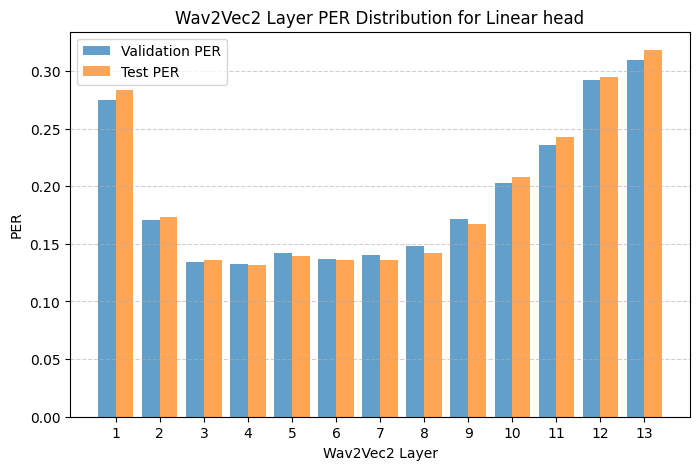

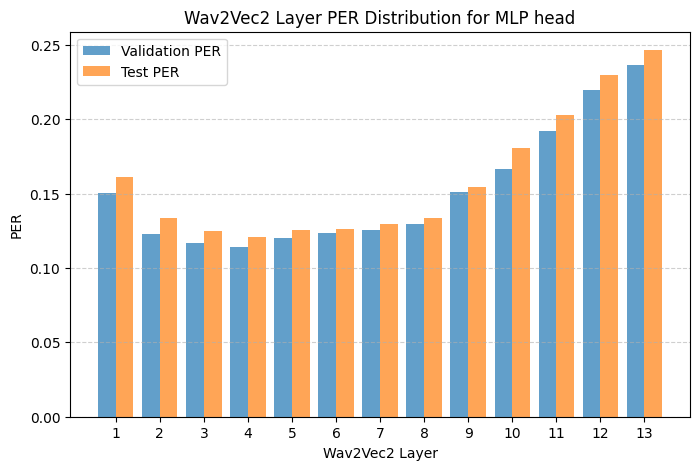

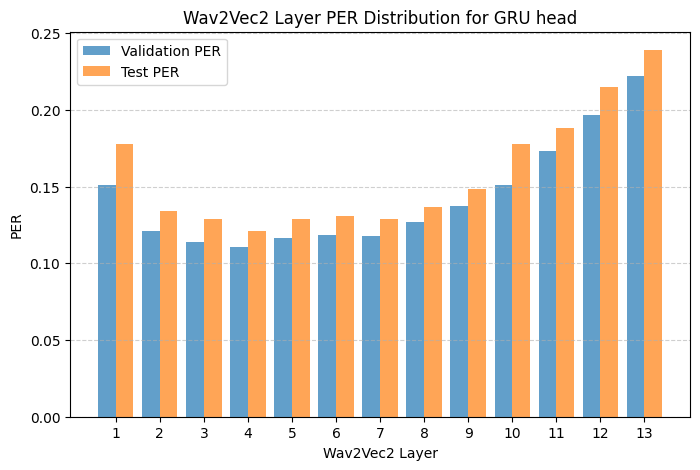

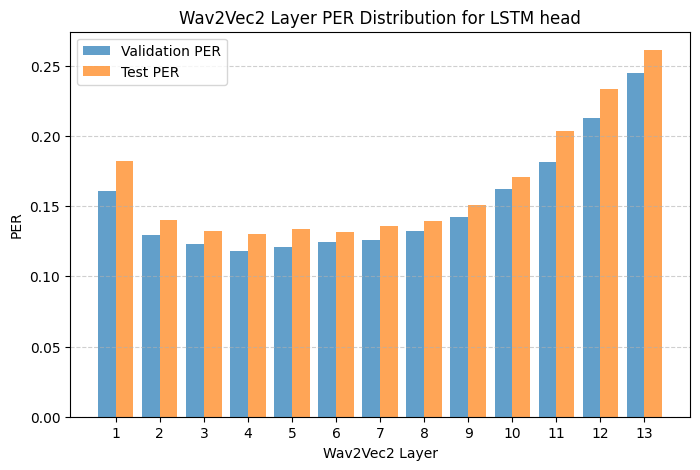

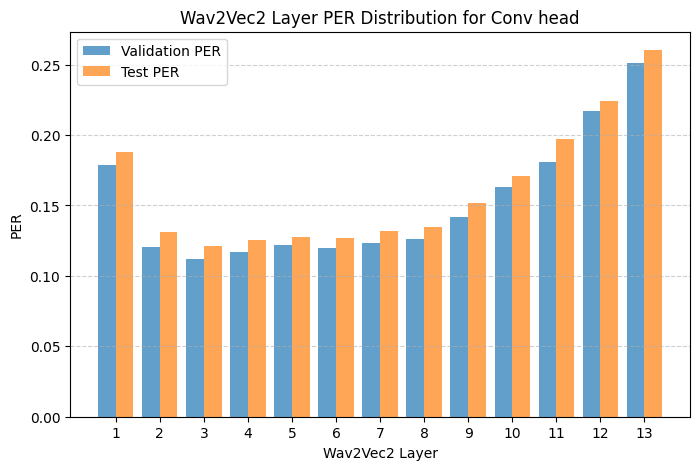

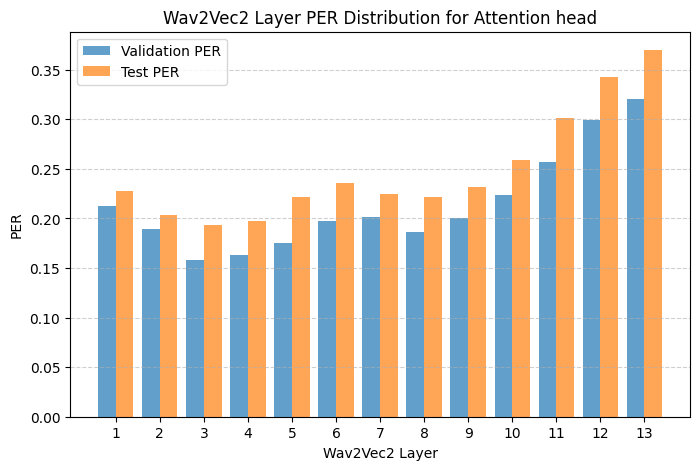

In [83]:
for i in range(len(model_name)):
    plot_layer_accuracy_hist(val_PER_per_layer, test_PER_per_layer, head_idx=i, models=model_name, ssl_model="Wav2Vec2")

We observe that the model performs best when using features from the third and fourth layers from the end. As we move closer to the initial layers, the performance gradually declines — a result that is fully expected, as earlier layers typically capture more low-level, less task-specific information.

Now let’s take a look at the results across different feature layers.

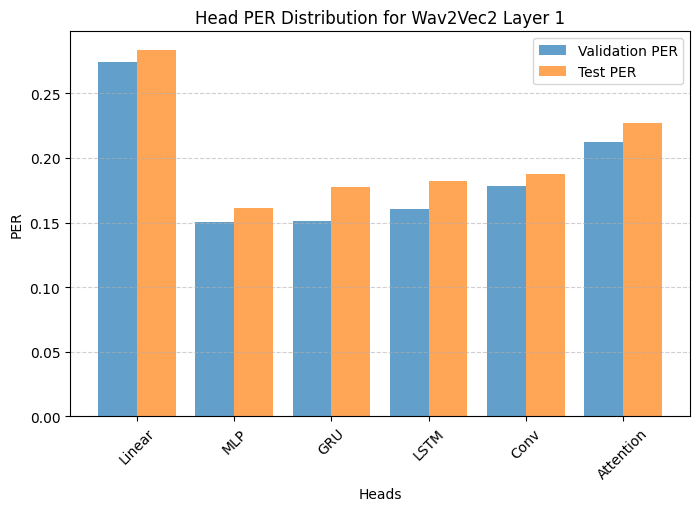

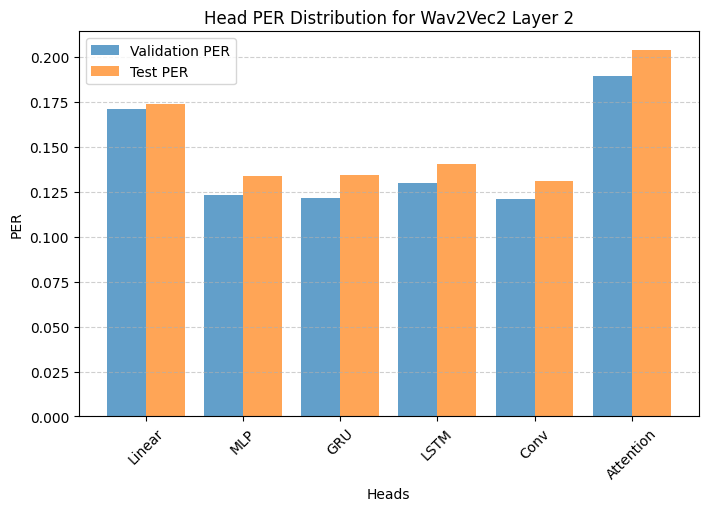

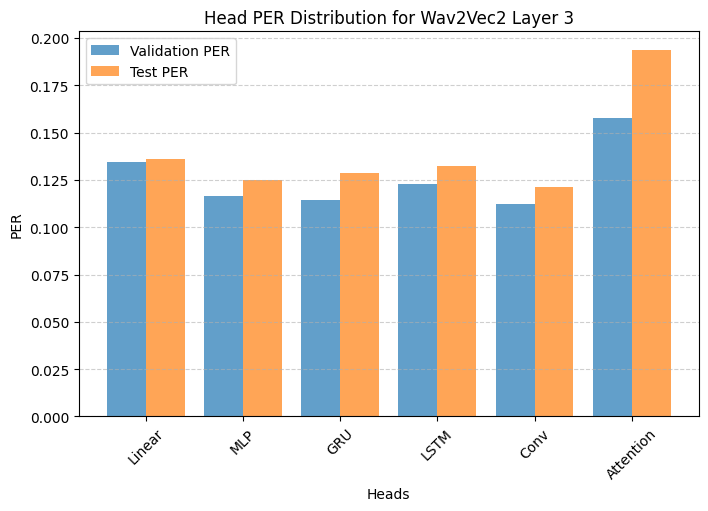

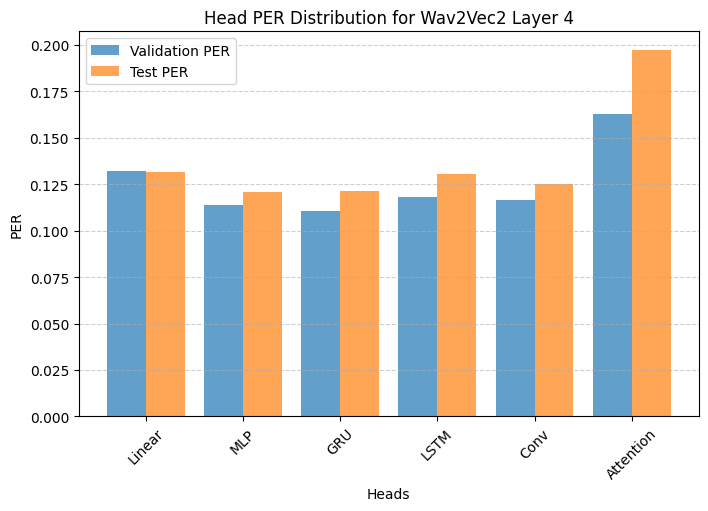

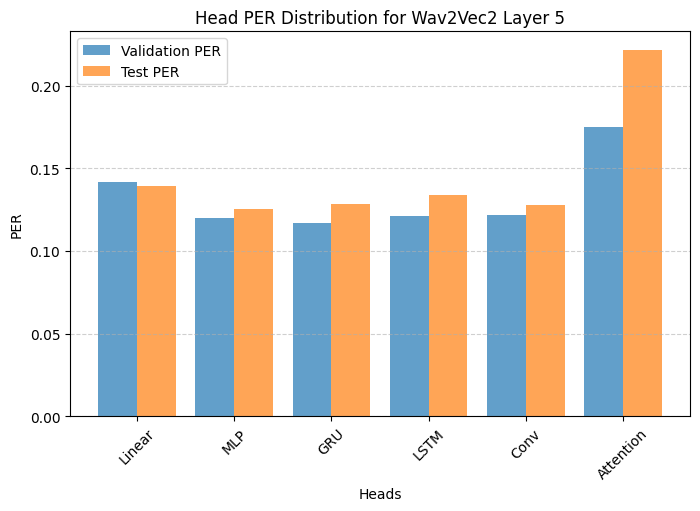

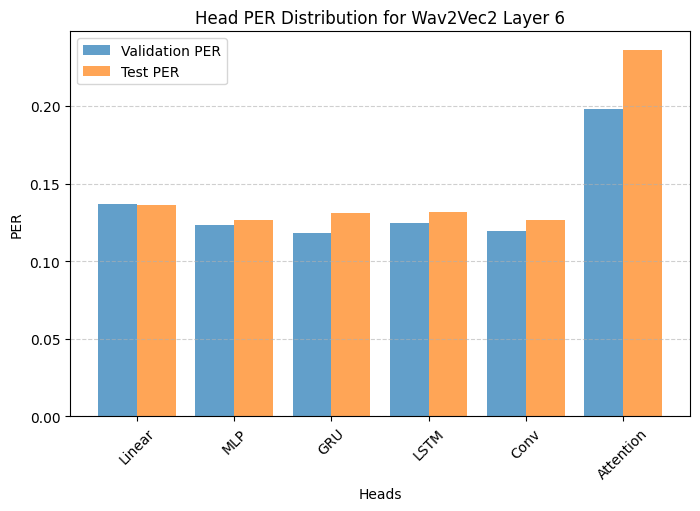

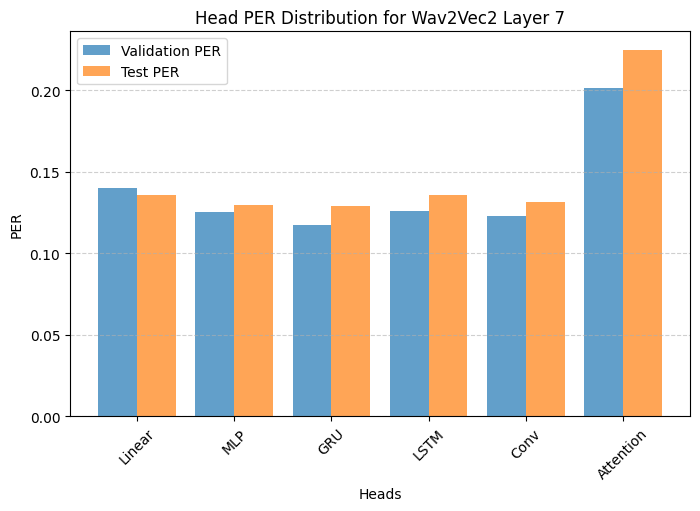

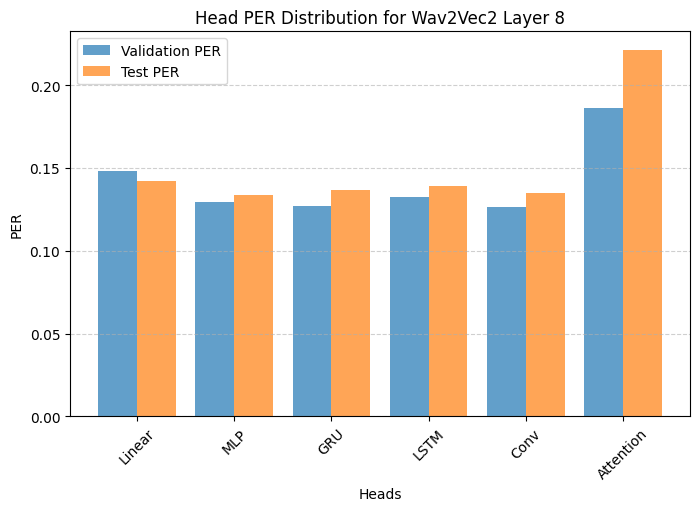

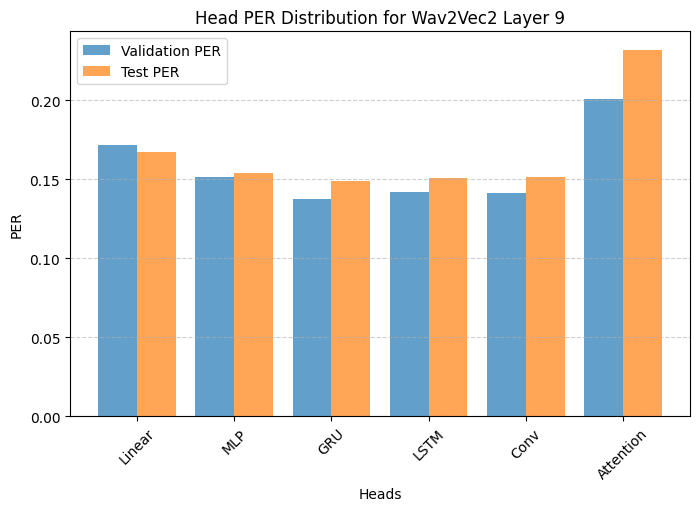

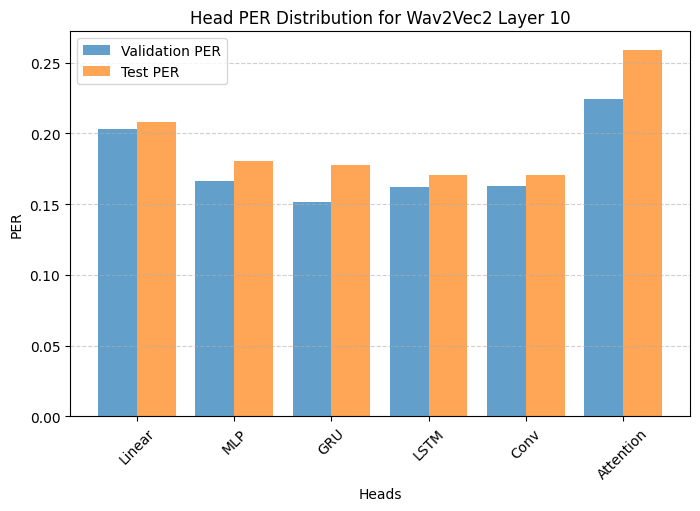

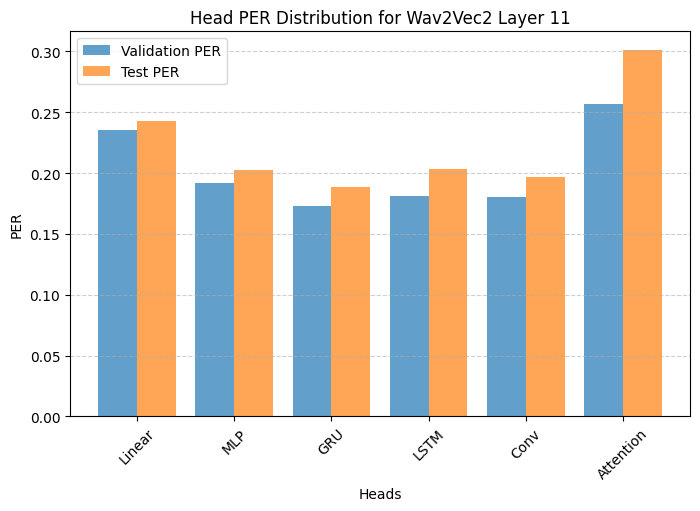

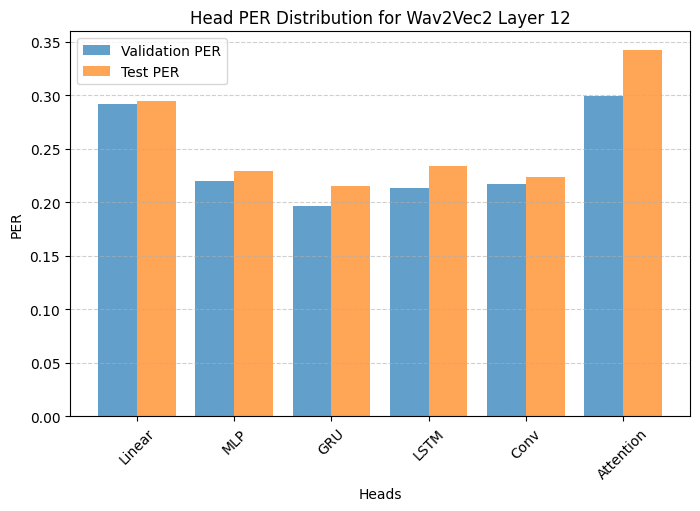

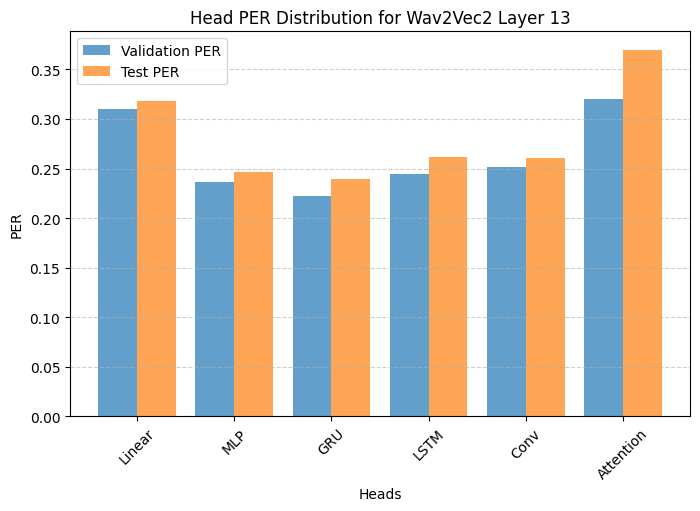

In [82]:
for i in range(num_layers):
    plot_model_accuracy_hist(val_PER_per_layer, test_PER_per_layer, layer_idx=i, models=model_name, ssl_model="Wav2Vec2")

We observe that the GRU Head achieves the best performance overall, while the Linear and Attention Heads perform the worst. Additionally, we visualize the best-performing input feature layer for each Head, as well as the best Head for each individual layer.

We also analyze the average performance across all Heads and layers.

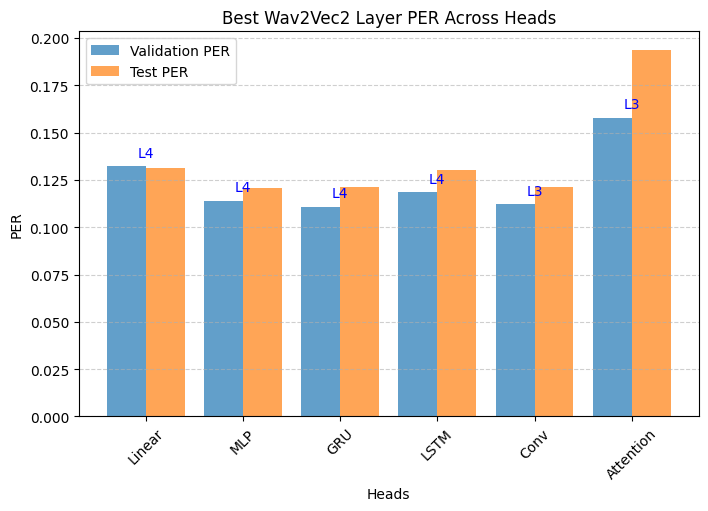

In [81]:
plot_best_layers_hist(val_PER_per_layer, test_PER_per_layer, models=model_name, ssl_model="Wav2Vec2")

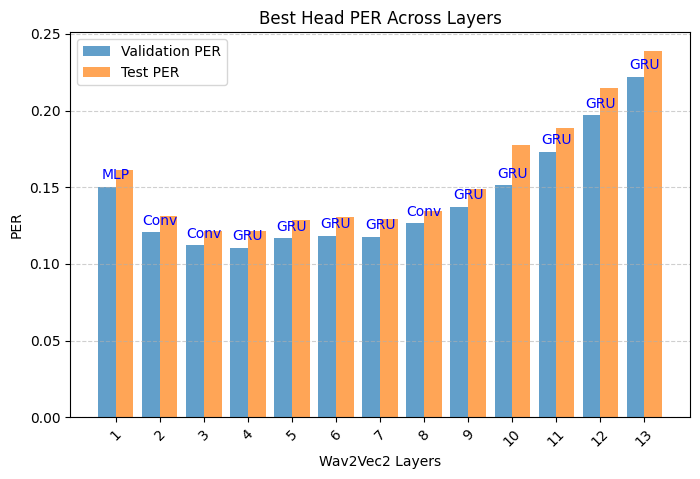

In [80]:
plot_best_heads_hist(val_PER_per_layer, test_PER_per_layer, models=model_name, ssl_model="Wav2Vec2")

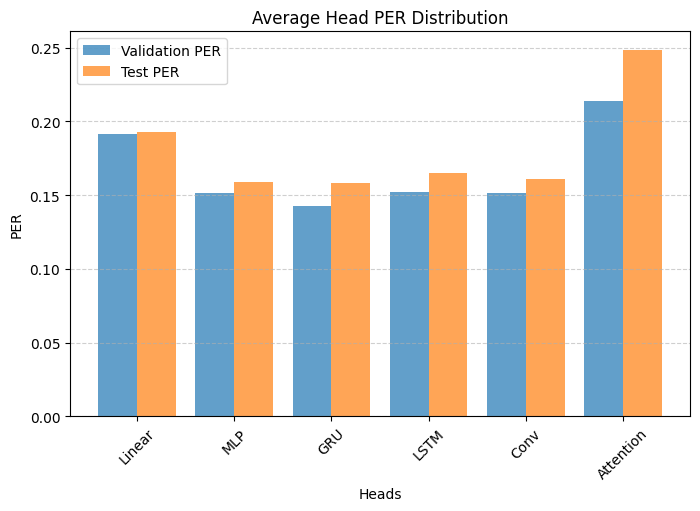

In [79]:
plot_model_accuracy_hist(val_PER_per_layer, test_PER_per_layer, layer_idx=-1, models=model_name, ssl_model="Wav2Vec2")

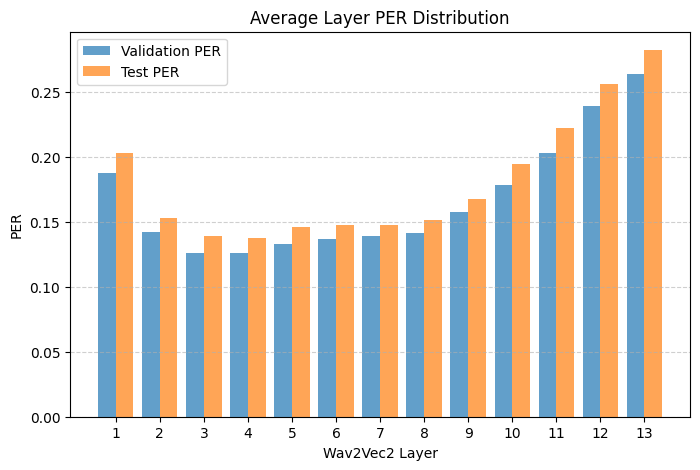

In [78]:
plot_layer_accuracy_hist(val_PER_per_layer, test_PER_per_layer, head_idx=-1, models=model_name, ssl_model="Wav2Vec2")

From this, we can conclude that for the phoneme recognition task, the most informative features in Wav2Vec2 are extracted from the fourth hidden layer from the end, and the best-performing Head is the GRU. The best overall result achieved with Wav2Vec2 was a PER of **0.1106** on the validation dataset and **0.1209** on the test dataset. This is slightly worse than the result reported by the original [Wav2Vec2](https://arxiv.org/pdf/2006.11477) authors (**0.116**).